# Table of Contents
 <p><div class="lev1 toc-item"><a href="#Dimension-reduction" data-toc-modified-id="Dimension-reduction-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Dimension reduction</a></div>

In [92]:
#library(ggbiplot)
library(tidyverse, quiet=T)

library(caret, quiet=T)

In [93]:


dat0 <- read.csv("../training_ultrasound.csv")

# Use Hadlok equation to estimate fetal weight from the 4 key ultrasound measurements
dat.raw = dat0 %>%
    mutate(
        LOG10.FWT.GM = 1.3596 + 0.0064*HCIRCM + 0.0424*ABCIRCM + 0.174*FEMURCM + 0.00061*BPDCM*ABCIRCM - 0.00386*ABCIRCM*FEMURCM,
        WTKG.estimate = ifelse(AGEDAYS<1 ,(10^LOG10.FWT.GM)/1000 ,WTKG) ,
        Study = paste('Study', STUDYID)
        )
# clean data, remove samples with only one observation and after-birth
dat = dat.raw %>% group_by(SUBJID) %>%
    mutate(tot.measurements = n()) %>%
    filter(tot.measurements >1) %>%
    filter(AGEDAYS<0)

# Dimension reduction

We use PCA to reduce the four physical variables to one single dimension

In [94]:
dat.train = dat %>% ungroup %>%
    select(GAGEDAYS, SUBJID, ABCIRCM, HCIRCM, BPDCM, FEMURCM) %>%
    filter(complete.cases(.))

dat.prcomp = dat.train  %>%
    select(-GAGEDAYS, -SUBJID) %>% 
    filter(complete.cases(.)) %>% 
    mutate_each(funs(as.numeric(.))) %>%
    prcomp(., center=T, scale.=T)

dat.prcomp$x %>% head

dat.train %>% nrow

PC1,PC2,PC3,PC4
-2.1289975,-0.08004799,-0.07709005,0.07635755
-0.8069757,0.21190839,-0.19208521,-0.02147109
-0.8069757,0.21190839,-0.19208521,-0.02147109
-1.7630474,0.01745379,-0.19676596,-0.19297972
-1.7630474,0.01745379,-0.19676596,-0.19297972
1.4857747,0.07214618,0.05610202,0.08553775


[1] 7940

In [95]:
PC1 = dat.prcomp$x %>% tbl_df %>% select(PC1) 

dat.train$PC1 = PC1$PC1
dat.train %>% head



GAGEDAYS,SUBJID,ABCIRCM,HCIRCM,BPDCM,FEMURCM,PC1
255,1002,32.5,33.4,9.1,7.3,-2.1289975
223,1003,25.6,29.2,8.2,6.3,-0.8069757
224,1003,25.6,29.2,8.2,6.3,-0.8069757
263,1003,30.2,31.0,9.1,7.2,-1.7630474
266,1003,30.2,31.0,9.1,7.2,-1.7630474
169,1005,18.7,21.9,5.9,4.1,1.4857747


In [96]:
dat.train = dat.train %>% group_by(SUBJID) %>%
    mutate(measurementId = row_number()) %>%
    ungroup

dat.times = dat.train %>% 
    select(SUBJID, measurementId, GAGEDAYS) %>% 
    spread(measurementId, GAGEDAYS) %>% 
#    filter(complete.cases(.)) %>% 
    as.matrix
dat.values = dat.train %>% 
    select(SUBJID, measurementId, PC1) %>%  
    spread(measurementId, PC1) %>% 
#    filter(complete.cases(.)) %>% 
    as.matrix

In [84]:
dat.times %>% head
dat.values %>% head


,SUBJID,1,2,3,4,5,6,7,8,9,10
1,1002,255,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1003,223,224,263,266,NA,NA,NA,NA,NA,NA
3,1005,169,222,264,NA,NA,NA,NA,NA,NA,NA
4,1006,222,266,NA,NA,NA,NA,NA,NA,NA,NA
5,1009,168,231,NA,NA,NA,NA,NA,NA,NA,NA
6,1011,168,219,261,NA,NA,NA,NA,NA,NA,NA


,SUBJID,1,2,3,4,5,6,7,8,9,10
1,1002,-2.1289975,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,1003,-0.8069757,-0.80697572,-1.763047,-1.763047,NA,NA,NA,NA,NA,NA
3,1005,1.4857747,-0.39214543,-1.568281,NA,NA,NA,NA,NA,NA,NA
4,1006,-0.8204526,-1.82614617,NA,NA,NA,NA,NA,NA,NA,NA
5,1009,1.8378790,-0.74333017,NA,NA,NA,NA,NA,NA,NA,NA
6,1011,1.7089330,-0.08472587,-1.292304,NA,NA,NA,NA,NA,NA,NA


In [97]:
library(traj)

In [98]:
s1 = step1measures(dat.values, dat.times, ID=T)

[1] "No correlations found. That is good."


In [99]:
s2 = step2factors(s1)

[1] "Computing reduced correlation e-values..."


In [101]:
s3 = step3clusters(s2,4 )

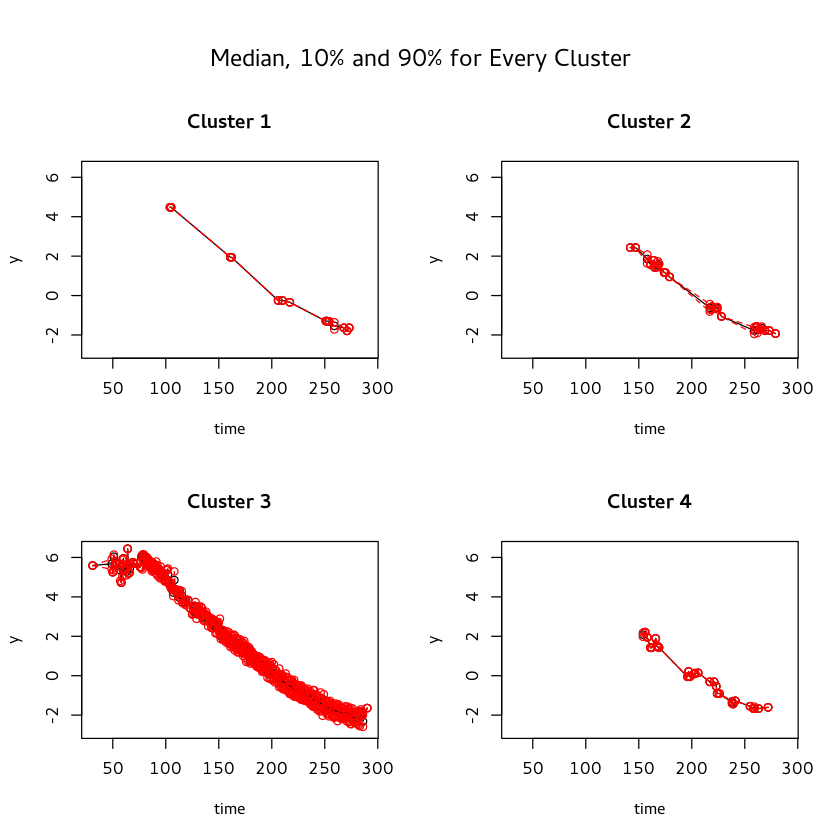

In [102]:
plotMedTraj(s3)

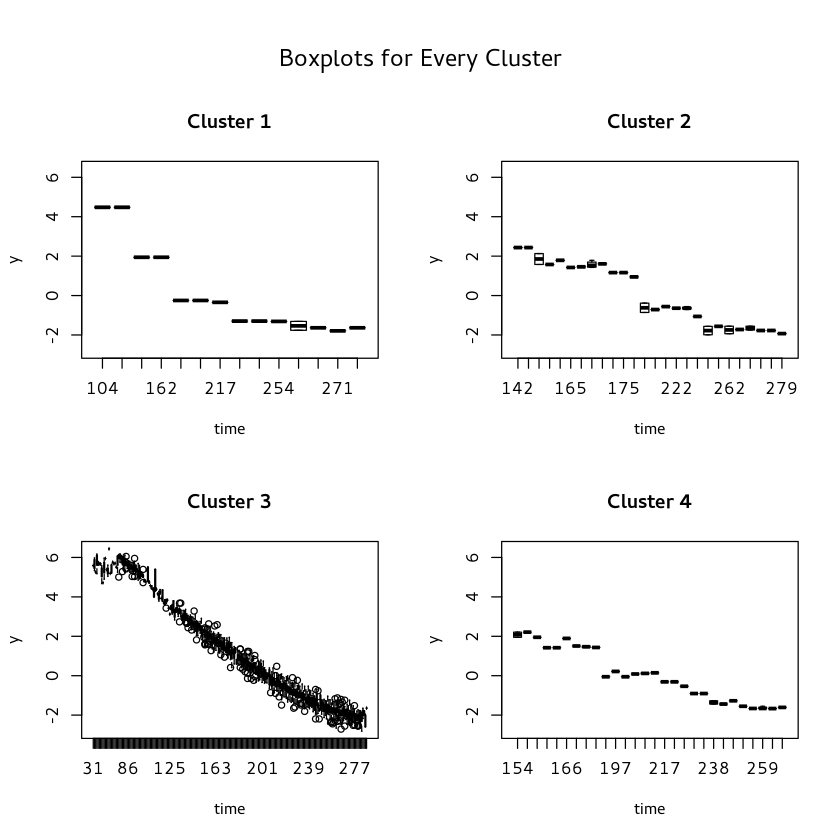